Posts with extracted locations: 20 out of 850
Top mentioned locations: [('UK', 4), ('South Carolina', 3), ('Spain', 3), ('California', 2), ('Mexico', 2), ('Minnesota', 1), ('NC', 1), ('Italy', 1), ('Oregon', 1), ('Florida', 1)]
Successfully geocoded 10 locations
Total mappable crisis-related posts: 18
Folium heatmap saved as 'crisis_heatmap.html'
Top locations chart saved as 'top_crisis_locations.png'

Top 5 locations with highest crisis discussions:
1. UK: 12 crisis mentions (High-Risk)
2. South Carolina: 9 crisis mentions (High-Risk)
3. Spain: 9 crisis mentions (High-Risk)
4. California: 6 crisis mentions (High-Risk)
5. Mexico: 6 crisis mentions (High-Risk)


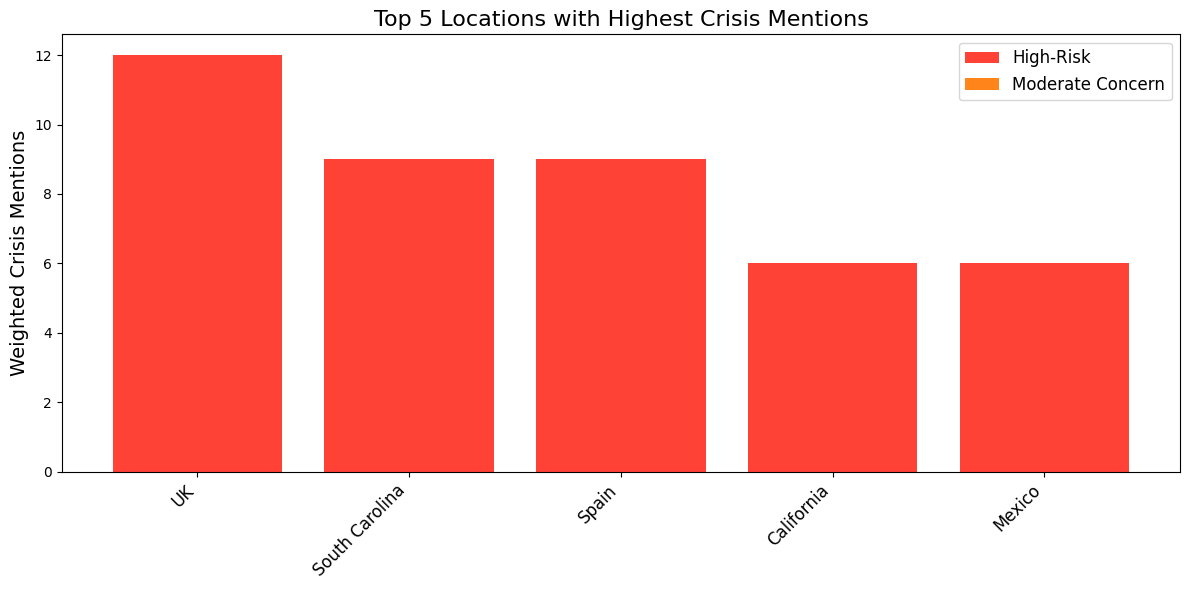

In [8]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from collections import Counter
import time
import spacy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable

reddit_df = pd.read_csv("/content/classified_reddit_posts.csv")
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("Downloading spaCy language model...")
    import spacy.cli
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

geolocator = Nominatim(user_agent="crisis_mapping_app", timeout=5)

US_STATES = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut",
    "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
    "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan",
    "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire",
    "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma",
    "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee",
    "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]

US_STATE_ABBREVS = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA",
    "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT",
    "VA", "WA", "WV", "WI", "WY", "DC"
]

MAJOR_CITIES = [
    "New York", "Los Angeles", "Chicago", "Houston", "Phoenix", "Philadelphia", "San Antonio",
    "San Diego", "Dallas", "San Jose", "Austin", "Jacksonville", "Fort Worth", "Columbus",
    "San Francisco", "Charlotte", "Indianapolis", "Seattle", "Denver", "Boston"
]

COUNTRIES = [
    "United States", "Canada", "UK", "United Kingdom", "Australia", "Germany", "France",
    "Japan", "China", "India", "Brazil", "Mexico", "Spain", "Italy", "Russia", "South Korea",
    "Ireland", "Scotland", "New Zealand", "South Africa"
]

VALID_LOCATIONS = set(US_STATES + US_STATE_ABBREVS + MAJOR_CITIES + COUNTRIES)

def extract_valid_locations(text):
    if pd.isna(text) or not isinstance(text, str):
        return []
    doc = nlp(text)
    locations = [ent.text for ent in doc.ents if ent.label_ in ["GPE", "LOC"]]
    location_patterns = [
        r"in\s+([A-Z][a-zA-Z\s]+),\s+([A-Z]{2})",
        r"in\s+([A-Z][a-zA-Z\s]+)",
        r"(?:from|near|at)\s+([A-Z][a-zA-Z\s]+)"
    ]

    for pattern in location_patterns:
        matches = re.findall(pattern, text)
        for match in matches:
            if isinstance(match, tuple):
                for loc in match:
                    if loc.strip() in VALID_LOCATIONS:
                        locations.append(loc.strip())
            else:
                if match.strip() in VALID_LOCATIONS:
                    locations.append(match.strip())
    valid_locations = []
    for loc in locations:
        if loc in VALID_LOCATIONS:
            valid_locations.append(loc)

    return list(set(valid_locations))

def geocode_location(location_str):
    try:
        if location_str in US_STATE_ABBREVS:
            location_str = f"{location_str}, US"

        location = geolocator.geocode(location_str, exactly_one=True)
        if location:
            return {
                'location': location_str,
                'latitude': location.latitude,
                'longitude': location.longitude,
                'address': location.address
            }
        return None
    except (GeocoderTimedOut, GeocoderUnavailable) as e:
        print(f"Geocoding error for location: {location_str} - {str(e)}")
        time.sleep(2)
        return None

reddit_df['extracted_locations'] = reddit_df['full_text'].apply(extract_valid_locations)
has_location = reddit_df[reddit_df['extracted_locations'].apply(len) > 0]
print(f"Posts with extracted locations: {len(has_location)} out of {len(reddit_df)}")


all_locations = []
for locations in reddit_df['extracted_locations']:
    all_locations.extend(locations)

top_locations = Counter(all_locations).most_common(10)
print("Top mentioned locations:", top_locations)

if top_locations:
    geocoded_locations = []
    for loc_name, count in top_locations:
        result = geocode_location(loc_name)
        if result:
            result['count'] = count
            geocoded_locations.append(result)
            time.sleep(2)

    if geocoded_locations:
        geo_df = pd.DataFrame(geocoded_locations)
        print(f"Successfully geocoded {len(geo_df)} locations")

        post_locations = []
        for idx, row in reddit_df.iterrows():
            risk_level = row['risk_level']
            if risk_level == "Low Concern":
                continue

            weight = 3 if risk_level == "High-Risk" else 1

            for loc_name in row['extracted_locations']:
                geo_match = geo_df[geo_df['location'] == loc_name]

                if len(geo_match) > 0:
                    match = geo_match.iloc[0]
                    post_locations.append({
                        'post_id': idx,
                        'location': loc_name,
                        'latitude': match['latitude'],
                        'longitude': match['longitude'],
                        'risk_level': risk_level,
                        'weight': weight
                    })
        if post_locations:
            heatmap_df = pd.DataFrame(post_locations)
            print(f"Total mappable crisis-related posts: {len(heatmap_df)}")
            def create_folium_heatmap(data_df):
                center_lat = data_df['latitude'].mean()
                center_lon = data_df['longitude'].mean()
                crisis_map = folium.Map(location=[center_lat, center_lon],
        zoom_start=2,
        tiles='OpenStreetMap',
        attr='OpenStreetMap contributors'
    )
                heat_data = [[row['latitude'], row['longitude'], row['weight']]
                            for _, row in data_df.iterrows()]
                HeatMap(heat_data, radius=15, max_zoom=13).add_to(crisis_map)
                location_data = data_df.groupby('location').agg({
                    'weight': 'sum',
                    'latitude': 'first',
                    'longitude': 'first',
                    'risk_level': lambda x: 'High-Risk' if 'High-Risk' in x.values else 'Moderate Concern'
                }).sort_values('weight', ascending=False)


                top5 = location_data.head(5)
                marker_group = folium.FeatureGroup(name="Top 5 Crisis Locations")

                for idx, row in top5.iterrows():
                    color = 'red' if row['risk_level'] == 'High-Risk' else 'orange'
                    marker = folium.Marker(
                        location=[row['latitude'], row['longitude']],
                        popup=f"{idx}: {row['weight']} crisis mentions ({row['risk_level']})",
                        icon=folium.Icon(color=color, icon='info-sign')
                    )
                    marker.add_to(marker_group)

                marker_group.add_to(crisis_map)
                folium.LayerControl().add_to(crisis_map)
                crisis_map.save('crisis_heatmap.html')
                print("Folium heatmap saved as 'crisis_heatmap.html'")

                return top5
            def create_top_locations_chart(top_locations_df):
                plt.figure(figsize=(12, 6))
                colors = ['#ff4136' if level == 'High-Risk' else '#ff851b'
                        for level in top_locations_df['risk_level']]

                plt.bar(top_locations_df.index, top_locations_df['weight'], color=colors)
                plt.title('Top 5 Locations with Highest Crisis Mentions', fontsize=16)
                plt.ylabel('Weighted Crisis Mentions', fontsize=14)
                plt.xticks(rotation=45, ha='right', fontsize=12)

                from matplotlib.patches import Patch
                legend_elements = [
                    Patch(facecolor='#ff4136', label='High-Risk'),
                    Patch(facecolor='#ff851b', label='Moderate Concern')
                ]
                plt.legend(handles=legend_elements, fontsize=12)

                plt.tight_layout()
                plt.savefig('top_crisis_locations.png', dpi=300)
                print("Top locations chart saved as 'top_crisis_locations.png'")

            top5_locations = create_folium_heatmap(heatmap_df)
            create_top_locations_chart(top5_locations)
            print("\nTop 5 locations with highest crisis discussions:")
            for i, (location, row) in enumerate(top5_locations.iterrows(), 1):
                print(f"{i}. {location}: {int(row['weight'])} crisis mentions ({row['risk_level']})")
        else:
            print("No locations could be mapped to coordinates.")
    else:
        print("Could not geocode any locations. ")

else:
    print("No valid locations found in the dataset.")